In [48]:
import numpy as np
import matplotlib.pyplot as plt

class DecisionStump:
    def __init__(self):
        # the direction of classification for each sample
        self.polarity = 1
        # id of a column
        self.feature_idx = None
        # determines whether the value should be 1 or -1
        self.threshold = None
        # weight of the classifier
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)

        # determining the value of a prediction
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column >= self.threshold] = -1

        return predictions


class AdaBoost:
    def __init__(self, n_classifiers=5):
        # initialize the classification with a specific num of learners
        self.n_classifiers = n_classifiers
        self.clfs = []
        self.errors = []  # initialize errors list
        self.misclassified_indices = []  # initialize misclassified indices list


    def fit(self, X, y):
        # initialize number of rows, and columns
        n_samples, n_features = X.shape
        # create a matrix of size n_samples, and assign the same weight to every sample
        weights = np.full(n_samples, (1 / n_samples))


        # create the classifiers
        for _ in range(self.n_classifiers):
            clf = DecisionStump()
            min_error = float('inf')

            # for each column in the data set calculate the thresholds
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)
                p = 1


                # calculate the number of miscalculated predctions
                for threshold in thresholds:
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    misclassified = weights[y != predictions]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # calculate the new weight (alpha) of the classifier
            EPS = 1e-10
            clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # reassign predctions and weights
            predictions = clf.predict(X)
            weights *= np.exp(-clf.alpha * y * predictions)
            weights /= np.sum(weights)
            self.clfs.append(clf)

            # track the error rate
            self.errors.append(min_error)

            # track misclassified points
            misclassified_points = np.where(predictions != y)[0] #[0] returns first element of the tuple
            self.misclassified_indices.append(misclassified_points)


    # create the prediction for the dataset, scaling each classifier by its weight
    def predict(self, X):
        return np.sign(np.sum([clf.alpha * clf.predict(X) for clf in self.clfs], axis=0))

    #create plotting function
    def plot_results(self, X, y):
      n_iterations = len(self.misclassified_indices) #number of boosting iterations
      fig, axes = plt.subplots(1, n_iterations + 1, figsize=(19, 5))  # create 1 row and n_iterations+1 columns

      # plot Misclassified Points for each iteration
      for i, misclassified_points in enumerate(self.misclassified_indices):

          # plot positive samples
          positive_samples = X[y == 1]
          axes[i].scatter(positive_samples[:, 0], positive_samples[:, 1], color='blue', marker='o', label="Positive Class")

          # plot negative samples
          negative_samples = X[y == -1]
          axes[i].scatter(negative_samples[:, 0], negative_samples[:, 1], color='red', marker='o', label="Negative Class")

          # plot misclassified points
          axes[i].scatter(X[misclassified_points, 0], X[misclassified_points, 1],
                          color='yellow', edgecolor='k', s=100, marker='x', label="Misclassified")

          # title and legend
          axes[i].set_title(f"Iteration {i+1}")
          axes[i].legend()

      # plot Error Rate on the last subplot
      axes[-1].plot(range(1, len(self.errors) + 1), self.errors, marker='o', color='r')
      axes[-1].set_xlabel("Iteration")
      axes[-1].set_ylabel("Error Rate")
      axes[-1].set_title("Error Rate per Iteration")

      # adjust layout and add spacing between subplots
      plt.subplots_adjust(wspace=0.4)
      plt.show()

In [49]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [50]:
# load and prepare data
data = load_breast_cancer()
X = data.data
y = data.target
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
# train the library classifiers
n_estimators = 4
adaboost = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)
adaboost.fit(X_train, y_train)
y_pred_1 = adaboost.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<ipython-input-48-f61e6e6496fa>:112: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[i].scatter(X[misclassified_points, 0], X[misclassified_points, 1],


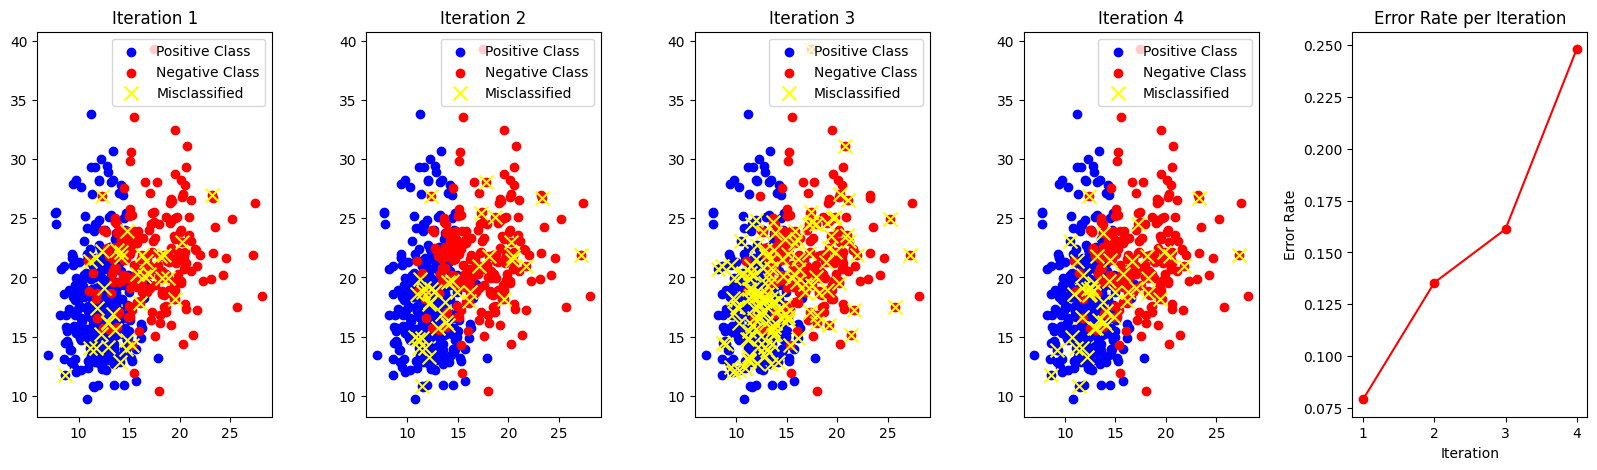

In [75]:
# train our implementation
adaboost_imp = AdaBoost(n_classifiers=4)
adaboost_imp.fit(X_train, y_train)
y_pred_2 = adaboost_imp.predict(X_test)
# plot results
adaboost_imp.plot_results(X, y)

In [76]:
# check accuracy for both implementations
acc = accuracy_score(y_test, y_pred_1)
print("Accuracy (library): ", acc)

acc2 = accuracy_score(y_test, y_pred_2)
print("Our implementation: ", acc2)

Accuracy (library):  0.9736842105263158
Our implementation:  0.9649122807017544
